In [124]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import os
from astropy.io import fits
import importlib.util
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.backends.backend_pdf
import re

In [125]:
# define functions to load architectures and pre-trained variables
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path, bands):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture(bands=bands)
    return g, nn

def load_backup(sess, graph, backup):
    with graph.as_default():
        saver = tf.train.Saver()
        saver.restore(sess, backup)

In [126]:
# load a neural net with the baseline architecture
graph, nn = load_arch("arch_baseline_amount.py", 4)
sess = tf.Session(graph=graph)

In [127]:
files = sorted(glob.glob('C:/Users/Andrew/Desktop/LBNL/challenge_data/GroundBasedTraining/npz/*.npz'))[10000:11000]
print(len(files))

# get small data set to test with - ALSO GET LABELS
imgs = []
labels = []
for i in range(10):
    img = np.load(files[i])['image']
    imgs.append(img)
    label = np.load(files[i])['is_lens']
    labels.append(label)
print(len(imgs), len(labels))

imgs = nn.prepare(np.array(imgs))
labels = np.array(labels)
print(imgs.shape, labels.shape)

1000
10 10
(10, 101, 101, 4) (10,)


In [128]:
# test data
X = []
y = []
for i in range(1000):
    x = np.load(files[i])['image']
    X.append(x)
    y_ = np.load(files[i])['is_lens']
    y.append(y_)

X = nn.prepare(np.array(X))
y = np.array(y)

In [132]:
test_preds=[]
test_actual=[]
train_preds=[]
train_actual=[]
iterations=[i for i in range(100,10001,100)]

with open('C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/stats_test.txt') as file:
    for line in file.readlines():
        line=line.split(' ')
        if line[0] != '#' and line[0] != '-1':
            probs=[]
            for i in range(1,len(line)):
                probs.append(float(line[i]))
            test_preds.append(probs)
        if line[0] == '-1':
             for i in range(1,len(line)):
                test_actual.append(float(line[i]))

with open('C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/stats_train.txt') as file:
    for line in file.readlines():
        line=line.split(' ')
        if line[0] != '#' and line[0] != '-1':
            probs=[]
            for i in range(1,len(line)):
                probs.append(float(line[i]))
            train_preds.append(probs)
        if line[0] == '-1':
             for i in range(1,len(line)):
                train_actual.append(float(line[i]))

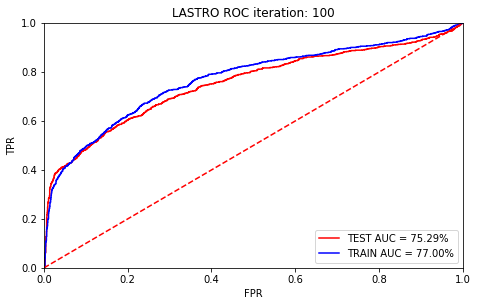

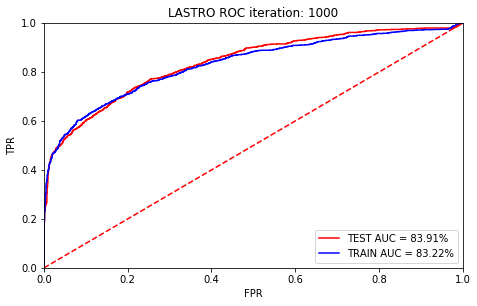

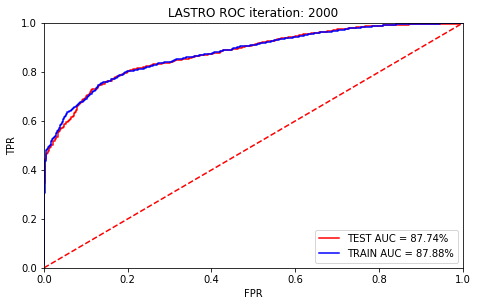

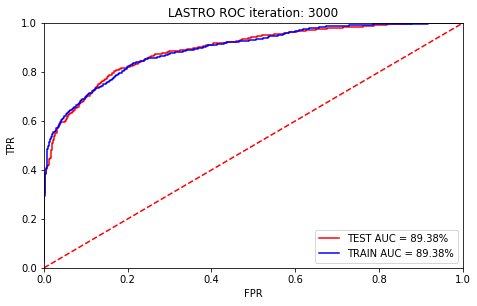

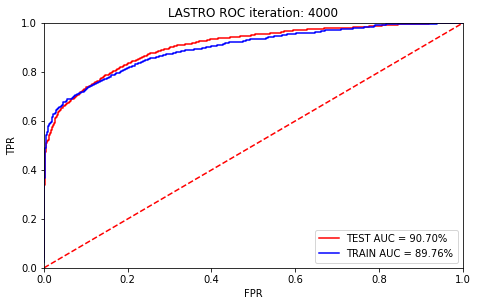

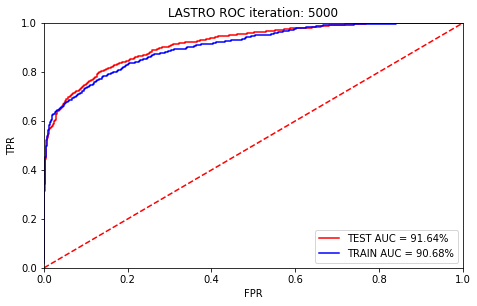

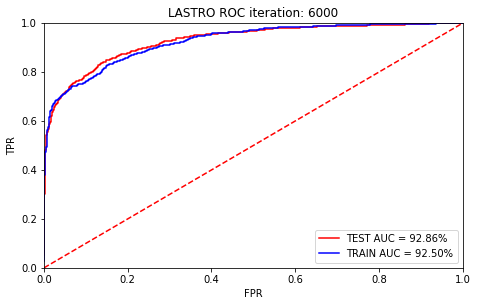

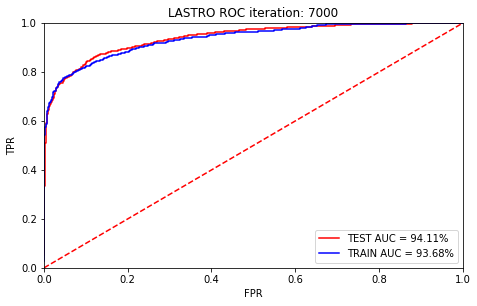

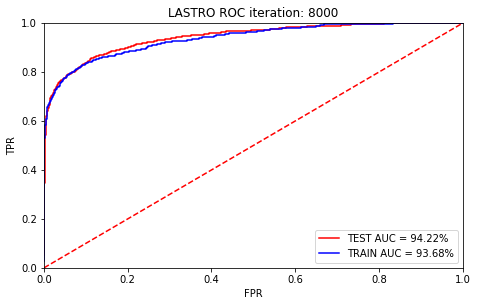

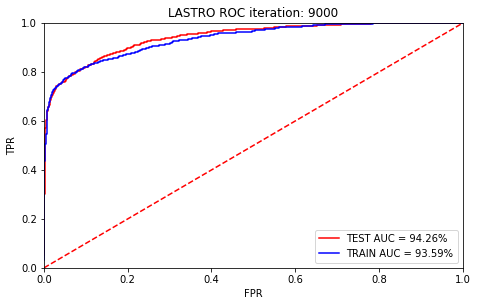

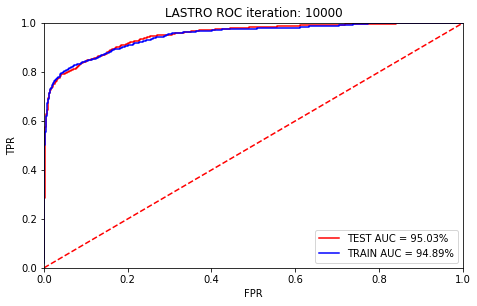

In [145]:
test_fpr, test_tpr, test_threshold = roc_curve(test_actual, test_preds[0])
test_roc_auc = auc(test_fpr, test_tpr)
train_fpr, train_tpr, train_threshold = roc_curve(train_actual, train_preds[0])
train_roc_auc = auc(train_fpr, train_tpr)

plt.figure(figsize=(7.5,4.5))
plt.title('LASTRO ROC iteration: {}'.format(iteration[0]))
plt.plot(test_fpr, test_tpr, 'r', label='TEST AUC = {:0.2f}%'.format(test_roc_auc*100))
plt.plot(train_fpr, train_tpr, 'b', label='TRAIN AUC = {:0.2f}%'.format(train_roc_auc*100))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

for i in range(9, 100, 10):   
#     load_backup(sess, graph, 'C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/iter/{:06d}.data'.format(i))
#     print("roc curve for iter {}".format(i))
#     preds = nn.predict(sess, X)
    
    test_fpr, test_tpr, test_threshold = roc_curve(test_actual, test_preds[i])
    test_roc_auc = auc(test_fpr, test_tpr)
    train_fpr, train_tpr, train_threshold = roc_curve(train_actual, train_preds[i])
    train_roc_auc = auc(train_fpr, train_tpr)
    
    plt.figure(figsize=(7.5,4.5))
    plt.title('LASTRO ROC iteration: {}'.format(iteration[i]))
    plt.plot(test_fpr, test_tpr, 'r', label='TEST AUC = {:0.2f}%'.format(test_roc_auc*100))
    plt.plot(train_fpr, train_tpr, 'b', label='TRAIN AUC = {:0.2f}%'.format(train_roc_auc*100))
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

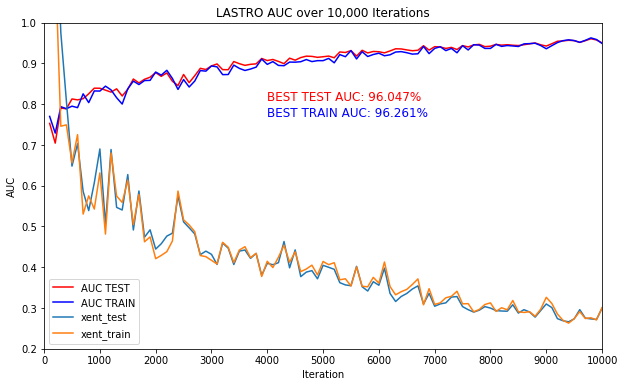

In [91]:
iteration=[]
xent_test=[]
auc_test=[]
xent_train=[]
auc_train=[]
with open('C:/Users/Andrew/Desktop/LBNL/LASTRO/output_10000_10000_finished/metrics.txt') as file:
#     print((file.readlines()))
    for line in file.readlines():
        line=line.split(' ')
        if line[0] != '#':
            iteration.append(int(line[0]))
            xent_test.append(float(line[1]))
            auc_test.append(float(line[2]))
            xent_train.append(float(line[3]))
            auc_train.append(float(line[4]))

plt.figure(figsize=(10,6))
plt.title('LASTRO AUC over 10,000 Iterations')
plt.plot(iteration, auc_test, c='red', label='AUC TEST')
plt.plot(iteration, auc_train, c='blue', label='AUC TRAIN')
plt.plot(iteration, xent_test, label='xent_test')
plt.plot(iteration, xent_train, label='xent_train')
plt.text(4000, 0.81, 'BEST TEST AUC: {:.3f}%'.format(max(auc_test)*100), fontsize=12, color='red')
plt.text(4000, 0.77, 'BEST TRAIN AUC: {:.3f}%'.format(max(auc_train)*100), fontsize=12, color='blue')
plt.legend(loc='best')
plt.xlim([100,10000])
plt.ylim([0.2,1])
plt.xticks(range(0,10001,1000))
plt.ylabel('AUC')
plt.xlabel('Iteration')
plt.show()